In [48]:
import torch
import numpy as np
import pandas as pd
import jieba
from torch.utils.data import DataLoader

处理raw数据，来源：https://github.com/pengming617/bert_classification/tree/master/data

参考：https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb

jieba:https://github.com/fxsjy/jieba

pytorch官网：https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

In [4]:
# 定义数据集
train_df = pd.read_csv("./train.tsv",sep='\t',header=0)
valid_df = pd.read_csv("./valid.tsv",sep='\t',header=0)
test_df = pd.read_csv("./test.tsv",sep='\t',header=0)

train_iter = list(zip(train_df.label, train_df.text_a))
valid_iter = list(zip(valid_df.label, valid_df.text_a))
test_iter = list(zip(test_df.label, test_df.text_a))

安装jieba,使用jieba用作tokenizer进行分词:

In [5]:
!pip install jieba

In [6]:
#使用jieba分词工具进行分词（tokenize）
def tokenizer(review):
  return list(jieba.cut(review))

创建词典（vocab）:

In [7]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)
    
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.765 seconds.
Prefix dict has been built successfully.


In [ ]:
#next(yield_tokens(train_iter))

In [ ]:
#vocab(['你好', '电动', '<unk>'])

In [8]:
# 文本处理，根据词典将文本转化为数字（numericalization）
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: x

In [ ]:
# 测试文本
# sample = '你好呀，这是一个测试文本。'
# processed_text1 = torch.tensor(text_pipeline(sample), dtype=torch.int64)
# print(processed_text1)
# print(processed_text1.size(0))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 定义 DataLoader函数内的处理函数collate_fn，用来处理可迭代的dataset数据，使之转化为DataLoader格式。
def collate_batch(batch):
  label_list, text_list, offsets = [], [], [0] # offsets是一个分隔符张量（分割文本中的每个单独的序列（句子）），用来表示文本中一个单独序列的起始序号。
  for (_label, _text) in batch:
    label_list.append(label_pipeline(_label)) 
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) #将数字化的文本转化为tensor张量
    text_list.append(processed_text)
    offsets.append(processed_text.size(0))

  label_list = torch.tensor(label_list, dtype=torch.int64) #将数字化的所有标签转化为tensor张量
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0) #将数字化的offsets转化为tensor张量,并累加，如一维offsets=[1,2,3],cumsum后offsets=[1,3,6]
  text_list = torch.cat(text_list) #将所有单独的文本，按照第一维进行堆叠

  return label_list.to(device), text_list.to(device), offsets.to(device)

In [10]:
#定义参数
num_class =len(set([label for (label, text) in train_iter]))
vocab_size =len(vocab)
emsize = 64
# Hyperparameters
epochs = 10
#lr = 5
lr = 0.1
batch_size = 64

构造DataLoader格式数据：

In [11]:
train_dataloader = DataLoader(train_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

定义模型函数：

In [12]:
from torch import nn
class SentClassificationModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_class):
    super(SentClassificationModel, self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
    self.fc = nn.Linear(embed_dim, num_class)
    self.init_weights()
  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc.weight.data.uniform_(-initrange, initrange)
    self.fc.bias.data.zero_()

  def forward(self, text, offsets):
    embedded = self.embedding(text, offsets)
    return self.fc(embedded)

In [13]:
model = SentClassificationModel(vocab_size, emsize, num_class).to(device)

In [14]:
import time
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs 

In [ ]:
def binaray_accuracy(preds, y):
  """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
  """
  # round predictions to the closest integer
  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds == y).float() # convert into float for division
  acc = correct.sum() / len(correct)
  return acc

In [41]:
def train(dataloader, optimizer, criterion):
  model.train()
  total_acc, total_count = 0, 0
  epoch_loss = 0

  log_interval = 50
  for idx, (label, text, offsets) in enumerate(dataloader):
    optimizer.zero_grad()
    predicted_label = model(text, offsets)
    loss = criterion(predicted_label, label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()
    
    total_acc += (predicted_label.argmax(1) == label).sum().item()
    total_count += label.size(0)

    epoch_loss += loss.item()

    if idx % log_interval == 0 and idx > 0:
      print(f'epoch{epoch:3d} | {idx}/{len(dataloader):5d}|loss:{epoch_loss/(idx+1):8.5f}| accuracy{total_acc/total_count:8.3f}')
      #total_acc, total_count = 0, 0
  return epoch_loss / len(dataloader) , total_acc /  total_count

In [26]:
len(train_dataloader)

143

In [32]:
def evaluate(dataloader, criterion):
  model.eval()
  total_acc, total_count = 0,0
  epoch_loss = 0
  with torch.no_grad():
    for idx, (label, text, offsets) in enumerate(dataloader):
      predicted_label = model(text, offsets)
      loss = criterion(predicted_label, label)
      total_acc += (predicted_label.argmax(1) == label).sum().item()
      total_count += label.size(0)
      epoch_loss += loss.item()
  return epoch_loss / len(dataloader), total_acc/total_count

In [ ]:
def binaray_accuracy(preds, y):
  """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
  """ 
  return (preds.argmax(1) == y).sum().item()

In [ ]:
def count_parameters(model):
  # 统计模型的参数数量
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,246,274 trainable parameters


不使用torch.optim.lr_scheduler.StepLR：

In [21]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
  epoch_start_time = time.time()
  epoch_loss, epoch_acc = train(train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(valid_dataloader, criterion)

  epoch_end_time = time.time()
  elapsed_mins, elapsed_secs = epoch_time(epoch_start_time, epoch_end_time)
  print('-' * 59)
  print(f'end of epoch {epoch:3d} | train loss{epoch_loss:8.3f} | train acc{epoch_acc:8.3f}')
  print(f'end of epoch {epoch:3d} | valid loss{epoch_loss:8.3f} | valid acc{valid_acc:8.3f}')
  print(f'end of epoch {epoch:3d} | time:{elapsed_mins:5.2f}mins,{elapsed_secs:5.2f}secs')
  print('-' * 59)

epoch  1 | 50/  143|loss:0.5701296925544739| accuracy   0.718
epoch  1 | 100/  143|loss:0.6803712248802185| accuracy   0.719
-----------------------------------------------------------
end of epoch   1 | train loss   0.594 | train acc   0.718
end of epoch   1 | valid loss   0.594 | valid acc   0.732
end of epoch   1 | time: 0.00mins, 8.00secs
-----------------------------------------------------------
epoch  2 | 50/  143|loss:0.6189099550247192| accuracy   0.717
epoch  2 | 100/  143|loss:0.590615451335907| accuracy   0.720
-----------------------------------------------------------
end of epoch   2 | train loss   0.587 | train acc   0.726
end of epoch   2 | valid loss   0.587 | valid acc   0.736
end of epoch   2 | time: 0.00mins, 8.00secs
-----------------------------------------------------------
epoch  3 | 50/  143|loss:0.6179621815681458| accuracy   0.722
epoch  3 | 100/  143|loss:0.5810307860374451| accuracy   0.725
-----------------------------------------------------------
end of

使用torch.optim.lr_scheduler.StepLR：

In [69]:
model = SentClassificationModel(vocab_size, emsize, num_class).to(device)

In [70]:
epochs = 20
lr = 1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_acc = None
train_losses, train_accs = [], []
valid_losses, valid_accs = [], []


for epoch in range(1, epochs + 1):
  epoch_start_time = time.time()
  train_loss, train_acc = train(train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(valid_dataloader, criterion)

  if total_acc is not None and total_acc > valid_acc:
    scheduler.step()
  else:
    total_acc = valid_acc
  
  epoch_end_time = time.time()
  elapsed_mins, elapsed_secs = epoch_time(epoch_start_time, epoch_end_time)

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  valid_losses.append(valid_loss)
  valid_accs.append(valid_acc)  

  print('-' * 59)
  print(f'end of epoch {epoch:3d} | train loss{train_loss:8.5f} | train acc{train_acc:8.3f}')
  print(f'end of epoch {epoch:3d} | valid loss{valid_loss:8.5f} | valid acc{total_acc:8.3f}')
  print(f'end of epoch {epoch:3d} | time:{elapsed_mins:5.2f}mins,{elapsed_secs:5.2f}secs')
  print('-' * 59)
  

epoch  1 | 50/  143|loss: 0.67582| accuracy   0.578
epoch  1 | 100/  143|loss: 0.66108| accuracy   0.609
-----------------------------------------------------------
end of epoch   1 | train loss 0.65242 | train acc   0.623
end of epoch   1 | valid loss 0.61845 | valid acc   0.660
end of epoch   1 | time: 0.00mins,11.00secs
-----------------------------------------------------------
epoch  2 | 50/  143|loss: 0.60376| accuracy   0.692
epoch  2 | 100/  143|loss: 0.59631| accuracy   0.705
-----------------------------------------------------------
end of epoch   2 | train loss 0.58492 | train acc   0.713
end of epoch   2 | valid loss 0.56464 | valid acc   0.728
end of epoch   2 | time: 0.00mins, 8.00secs
-----------------------------------------------------------
epoch  3 | 50/  143|loss: 0.54351| accuracy   0.740
epoch  3 | 100/  143|loss: 0.54418| accuracy   0.742
-----------------------------------------------------------
end of epoch   3 | train loss 0.53480 | train acc   0.750
end of 

In [22]:
sent_label = {0: 'nes', 1: 'pos'}
def predict(text, text_pipeline):
  with torch.no_grad():
    text = torch.tensor(text_pipeline(text))
    output = model(text, torch.tensor([0]))
    return output.argmax(1).item() 

In [59]:
test_str = "你说王的男人一届一届打了多少幕后老大了了，改过吗？换汤不换药啊。你隔壁007什么的都在努力走感情路线，他能走吗？每次都就那么几个老登带个新人，走不了！没这个能力知道吗？历史瞎几把改，人家打架他瞪眼瞅，开隐身模式在空中跳伞，搞基治疗大腿风湿。再拍下去要霍霍二战了，二战霍霍完搞冷战，冷战搞完又重掘带英叛徒，接下来没戏可拍了。唯一的亮点儿子上前线那段，但搞个托马斯回旋给儿子搞死了，他儿子是真正的英雄，一位勇敢的理想主义者，后来想想，这样的结果虽然有些突兀，但合情合理，更能展现战争的残酷和那种紧张的气氛，也升华了儿子的人物形象。战场的氛围渲染的很好，夜晚拼刺刀那段很精彩。"
print(f'Sentment Predict result: {sent_label[predict(test_str, text_pipeline)]}')

Sentment Predict result: nes


In [54]:
print(train_losses)

[0.6676515307459798, 0.6019950334008757, 0.5465238736226008, 0.5063503626343253, 0.47607532893861093, 0.451907860023992, 0.4328232099126269, 0.4172377921901383, 0.4027469431186889, 0.39136990175380576]


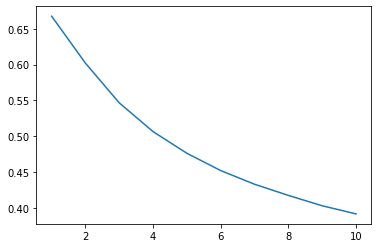

In [55]:
import matplotlib.pyplot as plt
plt.plot(range(1,epochs+1), train_losses, label='Training loss')

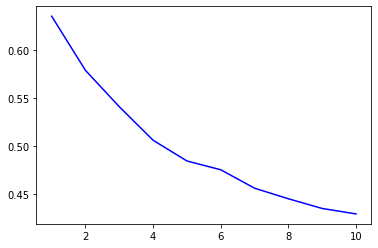

In [56]:
plt.plot(range(1,epochs+1), valid_losses, 'b', label='Valid loss')

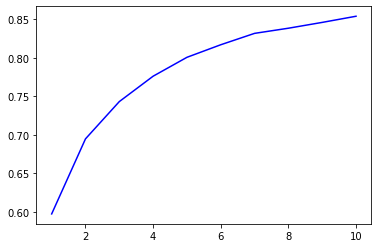

In [57]:
plt.plot(range(1,epochs+1), train_accs, 'b', label='Training accuracy')

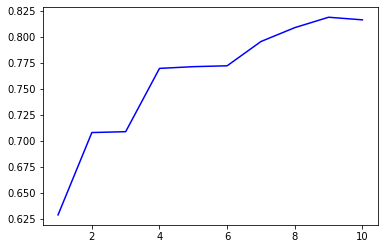

In [58]:
plt.plot(range(1,epochs+1), valid_accs, 'b', label='Valid accuracy')

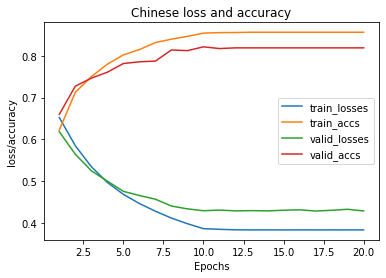

In [71]:
fig, ax = plt.subplots()
x = range(1,epochs+1)
y1 = train_losses
ax.plot(x, y1, label='train_losses')
y2 = train_accs
ax.plot(x, y2, label='train_accs')
y3 = valid_losses
ax.plot(x, y3, label='valid_losses')
y4 = valid_accs
ax.plot(x, y4, label='valid_accs')

ax.set_xlabel('Epochs')
ax.set_ylabel('loss/accuracy')
ax.set_title('Chinese Sentiment loss and accuracy')
ax.legend()
plt.show()

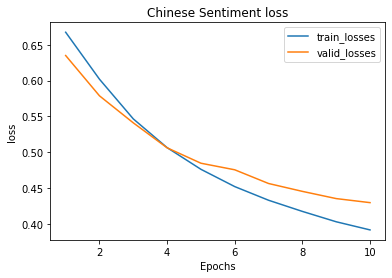

In [67]:
fig, ax = plt.subplots()
x = range(1,epochs+1)
y1 = train_losses
ax.plot(x, y1, label='train_losses')
y2 = valid_losses
ax.plot(x, y2, label='valid_losses')


ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Chinese Sentiment loss')
ax.legend()
plt.show()

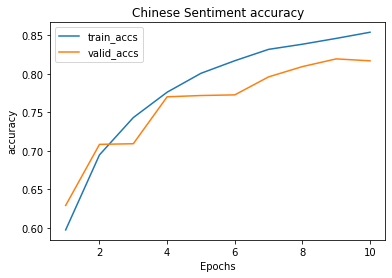

In [68]:
fig, ax = plt.subplots()
x = range(1,epochs+1)

y3 = train_accs
ax.plot(x, y3, label='train_accs')
y4 = valid_accs
ax.plot(x, y4, label='valid_accs')

ax.set_xlabel('Epochs')
ax.set_ylabel('accuracy')
ax.set_title('Chinese Sentiment accuracy')
ax.legend()
plt.show()

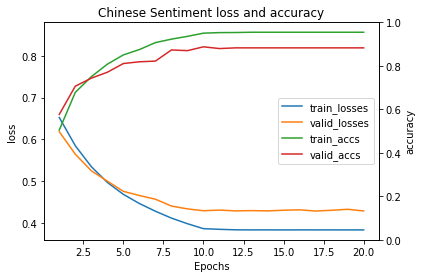

In [74]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()

ax1 = ax.twinx()
x = range(1,epochs+1)
y1 = train_losses
ax.plot(x, y1, label='train_losses')
y3 = valid_losses
ax.plot(x, y3, label='valid_losses')

y2 = train_accs
ax.plot(x, y2, label='train_accs')
y4 = valid_accs
ax.plot(x, y4, label='valid_accs')

ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax1.set_ylabel('accuracy')
ax.set_title('Chinese Sentiment loss and accuracy')
ax.legend()
plt.show()